# Solving Ordinary Differential Equations (ODEs) using a Physics-Informed Neural Network (PINN)
Let's solve the following ODE as an example:

$$\frac{dy}{dt}=f(t,y),\quad y(t_0)=y_0$$​

where $f(t,y)$ is some known function, and $y(t_0)=y_0$​ is the initial condition.

As an illustrative example, let's choose a simple ODE:

$$\frac{dy}{dt}=−2y, \quad y(0)=1$$

This is an exponential decay problem, whose solution is
$$y(t)=e^{−2t}.$$



**Step 1: Define the Neural Network**

Create a neural network that takes temporal coordinates as inputs and outputs the solution to the ODE at those points. Ensure that the network has enough capacity (layers and neurons) to capture the complexity of the solution.

In [3]:
import torch
import torch.nn as nn

class ODE_Net(nn.Module):
    def __init__(self):
        super(ODE_Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.net(x)


**Step 2: Define the Loss Function for the ODE**

The loss function should include the ODE's residual (the difference between the left-hand side and right-hand side of the ODE).

In [4]:
def eval_loss_ode(y_pred, t):
    # [0] is given to take the torch tensor and not the tuple
    dydt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # ODE residual (dy/dt + 2y = 0)
    loss_ode = ((dydt + 2*y_pred).pow(2)).mean()

    return loss_ode



**Step 3: Define the Loss Function for enforcing initial conditions**

The loss function should include the initial condition.

In [5]:
def eval_loss_ic(y_pred_0, y0):
    # Enforce the initial condition
    loss_ic = (y_pred_0 - y0).pow(2)

    return loss_ic

**Step 4: Prepare Training Data**

Generate collocation points for calculating the residuals, and points for enforcing initial conditions. These can be randomly sampled or placed on a grid.


In [8]:
t0 = torch.tensor([[0.0]])
y0 = torch.tensor([[1.0]])  # Initial condition
print(t0, t0.shape)
print(y0, y0.shape)
num_train_points = 20
t = torch.rand([num_train_points, 1])  # Sample 100 points
# Multiply t with 5 to increase the final time to 5
print(t, t.shape)

tensor([[0.]]) torch.Size([1, 1])
tensor([[1.]]) torch.Size([1, 1])
tensor([[0.5651],
        [0.9317],
        [0.7207],
        [0.4921],
        [0.9740],
        [0.0244],
        [0.9698],
        [0.1438],
        [0.1512],
        [0.8947],
        [0.4483],
        [0.1622],
        [0.2043],
        [0.2154],
        [0.2864],
        [0.8945],
        [0.7934],
        [0.4064],
        [0.8642],
        [0.2087]]) torch.Size([20, 1])


Text(0.5, 1.0, '1D Collocation Points')

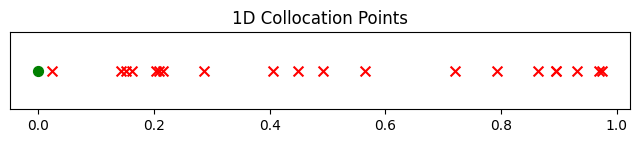

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 1))  # Width, Height
plt.scatter(t, np.zeros_like(t), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(t0, np.zeros_like(t0), color='green', s=50, label='Collocation Points')
plt.yticks([])  # Hide y-axis as it's irrelevant in 1D
plt.gca().axes.get_yaxis().set_visible(False)  # Another way to hide y-axis elements
plt.title('1D Collocation Points')

**Step 5: Train the Neural Network**

In [ ]:
model = ODE_Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

losses = []
losses_ode = []
losses_ics = []


for epoch in range(num_epochs):
    t.requires_grad = True

    # predict in the interior part
    y_pred = model(t)
    loss_ode = eval_loss_ode(y_pred, t)

    # predict the initial condition
    y_pred_0 = model(t0)  # y(0)
    loss_ic = eval_loss_ic(y_pred_0, y0)

    # add all loss componenets
    total_loss = loss_ode + loss_ic

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    losses_ode.append(loss_ode.item())
    losses_ics.append(loss_ic.item())

    if (epoch+1) % 100 == 0:
        print ('Epoch [{:4d}/{:4d}], Total Loss: {:.4e}  ODE Loss: {:.4e}  IC Loss: {:.4e}'.format(
            epoch+1, num_epochs, total_loss.item(), loss_ode.item(), loss_ic.item()))


Epoch [ 100/1000], Total Loss: 6.6129e-01  ODE Loss: 8.2971e-02  IC Loss: 5.7832e-01
Epoch [ 200/1000], Total Loss: 2.9098e-01  ODE Loss: 1.1153e-01  IC Loss: 1.7946e-01
Epoch [ 300/1000], Total Loss: 1.9054e-01  ODE Loss: 1.2058e-01  IC Loss: 6.9958e-02
Epoch [ 400/1000], Total Loss: 1.1260e-01  ODE Loss: 7.7310e-02  IC Loss: 3.5286e-02
Epoch [ 500/1000], Total Loss: 5.3342e-02  ODE Loss: 3.9358e-02  IC Loss: 1.3984e-02
Epoch [ 600/1000], Total Loss: 2.2131e-02  ODE Loss: 1.7851e-02  IC Loss: 4.2795e-03
Epoch [ 700/1000], Total Loss: 1.0765e-02  ODE Loss: 9.5337e-03  IC Loss: 1.2311e-03
Epoch [ 800/1000], Total Loss: 7.0484e-03  ODE Loss: 6.6125e-03  IC Loss: 4.3590e-04
Epoch [ 900/1000], Total Loss: 5.2074e-03  ODE Loss: 4.9952e-03  IC Loss: 2.1215e-04
Epoch [1000/1000], Total Loss: 3.9011e-03  ODE Loss: 3.7749e-03  IC Loss: 1.2623e-04


**Step 6: Plotting the losses**

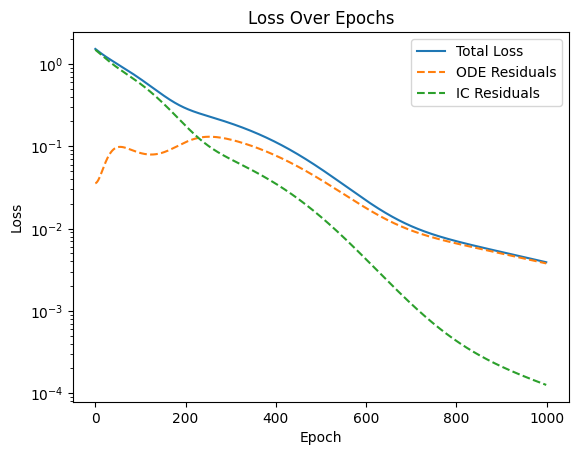

In [ ]:
import matplotlib.pyplot as plt

plt.semilogy(losses, label='Total Loss')
plt.semilogy(losses_ode, label='ODE Residuals', linestyle='--')
plt.semilogy(losses_ics, label='IC Residuals', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

**Step 7a: Evaluate the Solution on testing data**

After training, you can evaluate the model by comparing its predictions with the exact solution $y(x)=e^{−2x}$.


In [ ]:
t_test = torch.linspace(0, 1, 100).unsqueeze(1)  # Evaluate from 0 to 1
y_pred = model(t_test).detach().numpy()

**Step 7b: Visualization the solution**

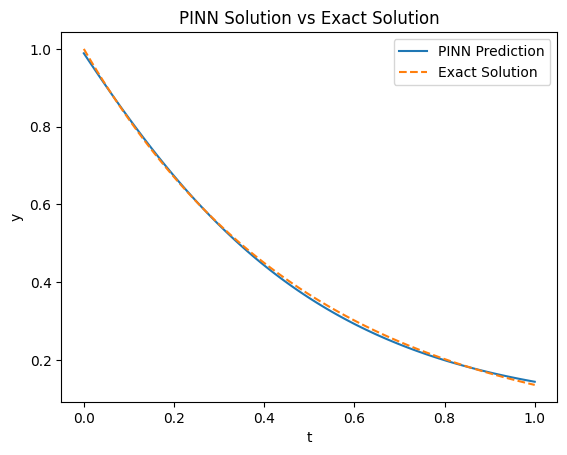

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_exact = np.exp(-2 * t_test.numpy())
plt.plot(t_test.numpy(), y_pred, label='PINN Prediction')
plt.plot(t_test.numpy(), y_exact, label='Exact Solution', linestyle='--')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title('PINN Solution vs Exact Solution')
plt.show()

**Step 7c: Plot the error**

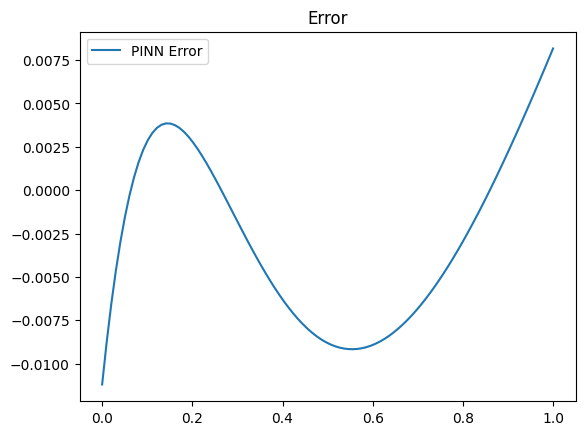

In [ ]:
import numpy as np
error = (y_pred - y_exact)
plt.plot(t_test.numpy(), error, label='PINN Error')
plt.legend()
plt.title('Error')
plt.show()